# Preprocessing des données

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
import pandas as pd
import io

#chargement pour google colab
#path = '/content/drive/MyDrive/Colab Notebooks/eco2mix-regional-cons-def.csv'
#df = pd.read_csv(path, sep = ';');

#chargement local
df = pd.read_csv('eco2mix-regional-cons-def.csv', sep=';')

C:\Users\romat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,56,58,60,62,64) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel, VarianceThreshold
from sklearn import preprocessing, model_selection

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels
import statsmodels.api as sm
import scipy.stats

import datetime
%matplotlib inline

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#compte de lignes et compte des NA
print(f'Nombre de lignes total = {len(df)}')
df.isna().sum()

Nombre de lignes total = 1787328


Code INSEE région                                                 0
Région                                                            0
Nature                                                            0
Date                                                              0
Heure                                                             0
Date - Heure                                                      0
Consommation (MW)                                                12
Thermique (MW)                                                   12
Nucléaire (MW)                                               744727
Eolien (MW)                                                     108
Solaire (MW)                                                     12
Hydraulique (MW)                                                 12
Pompage (MW)                                                 779767
Bioénergies (MW)                                                 12
Ech. physiques (MW)                             

### Suppression des colonnes et lignes inutiles et gestion des NA 
Comme vu dans le tableau ci-dessus, certaines colonnes ont un grand nombre de valeurs manquantes (plus de 80% des données). Nous allons supprimer les TCH et les flux car peu significatifs. Pour les TCO, il s'agit des taux de couverture de la consommation seulement calculés après 2020. Nous allons les calculer pour les années précédentes. 

Pour le reste, en ce qui concerne les données en MW, nous allons remplacer les données manquantes par des 0 (car il s'agit de régions sans production nucléaire par exemple) et nous allons supprimer 2 colonnes techniques ainsi que les lignes sans aucune donnée (au nombre de 12).

In [5]:
#drop des colonnes vides ou quasiment vides (les TCO sont les taux de couverture par filière, les flux sont incomplets, le TCH est inconnu)

filter_col2 = [col for col in df if col.startswith('TCH')]
filter_col3 = [col for col in df if col.startswith('Flux')]
filter_col = filter_col2 + filter_col3

df = df.drop(filter_col,axis=1)

#drop des colonnes inutiles (techniques)
df = df.drop(['Nature'],axis=1)

In [6]:
#drop des lignes sans data de consommation ou production
float_list = list(df.select_dtypes('float64').columns)
df = df.dropna(subset=float_list, how='all', axis=0)

#remplissage des NA par des 0 sur les colonnes de consommation et production
for column in float_list:
    df[column].fillna(0, inplace=True)
    
#remplissage des NAN des colonnes de taux de couverture de la consommation par le calcul correspondant
df['TCO Thermique (%)'].fillna((df['Thermique (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Nucléaire (%)'].fillna((df['Nucléaire (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Eolien (%)'].fillna((df['Eolien (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Solaire (%)'].fillna((df['Solaire (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Hydraulique (%)'].fillna((df['Hydraulique (MW)'] / df['Consommation (MW)']*100), inplace=True)
df['TCO Bioénergies (%)'].fillna((df['Bioénergies (MW)'] / df['Consommation (MW)']*100), inplace=True)

### Création de nouvelles variables
En premier lieu, des colonnes pour agréger certaines données en MW (renouvelables, un solde brut sans transfert, un solde net avec transfert). Ensuite, nous allons créer des taux de couverture de la consommation. Enfin, nous allons extraire les données liées à la date de chaque ligne.

In [7]:
#feature engineering (création de colonnes agrégées)

df['Renouvelables (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Pompage (MW)']
df['Solde brut (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)'] - df['Consommation (MW)']
df['Solde avec transferts (MW)'] = df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)'] + df['Ech. physiques (MW)'] - df['Consommation (MW)']
#remarque sur le pompage: uniquement des valeurs négatives donc représente la consommation d'électricité pour alimenter les pompes des stations de transfert d'énergie (STEP). La production doit alors être classifiée dans l'hydraulique.


#Taux de couvetures de la consommation

df['Taux Couverture (MW)'] = (df['Eolien (MW)'] + df['Solaire (MW)'] + df['Hydraulique (MW)'] + df['Bioénergies (MW)'] + df['Thermique (MW)'] + df['Nucléaire (MW)'] + df['Pompage (MW)']) / df['Consommation (MW)']
df['Taux Couverture Renouvelables (MW)'] = df['Renouvelables (MW)'] / df['Consommation (MW)']

In [8]:
#Mise au format date et extraction des éléments de la date en tant que colonnes
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.weekday
df['Jour'] = df['Date'].dt.day
df['Mois'] = df['Date'].dt.month
df['Trimestre'] = pd.PeriodIndex(df['Date'], freq='Q').astype('string') # alternative: ((x.month-1)//3) +1
df['Année'] = df['Date'].dt.year
df['Heure'] = pd.to_datetime(df['Heure'], format='%H:%M').dt.time #alternative: format='%H:%M:%S'
df['Date - Heure'] = pd.to_datetime(df['Date - Heure'], utc=True)

In [9]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,Code INSEE région,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),TCO Thermique (%),TCO Nucléaire (%),TCO Eolien (%),TCO Solaire (%),TCO Hydraulique (%),TCO Bioénergies (%),Renouvelables (MW),Solde brut (MW),Solde avec transferts (MW),Taux Couverture (MW),Taux Couverture Renouvelables (MW),Weekday,Jour,Mois,Année
count,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00,1787316.00
mean,49.92,4499.02,373.95,3678.17,246.14,86.14,608.51,-65.87,81.66,-510.03,1.33,15.09,1.66,0.54,2.12,0.39,956.58,509.67,-0.36,1.22,0.20,3.00,15.72,6.35,2016.76
std,25.64,2173.38,537.57,3876.44,412.40,209.85,1040.19,243.05,44.55,4372.91,4.72,56.66,6.26,3.03,8.60,0.90,1117.32,4372.87,5.63,1.23,0.18,2.00,8.80,3.45,2.46
min,11.00,895.00,-83.00,-144.00,-6.00,-23.00,-14.00,-2570.00,4.00,-12219.00,-2.54,-2.98,-0.10,-0.08,-1.06,0.00,-1280.00,-13960.00,-704.00,-0.18,-0.24,0.00,1.00,1.00,2013.00
25%,27.75,2789.00,24.00,0.00,26.00,0.00,5.00,-1.00,46.00,-4264.00,0.00,0.00,0.00,0.00,0.00,0.00,192.00,-2229.00,-1.00,0.20,0.06,1.00,8.00,3.00,2015.00
50%,48.00,4111.00,153.00,2583.00,101.00,0.00,57.00,0.00,72.00,473.00,0.00,0.00,0.00,0.00,0.00,0.00,471.00,-473.00,0.00,0.90,0.14,3.00,16.00,6.00,2017.00
75%,75.25,5741.00,480.00,6845.00,289.00,63.00,897.00,0.00,114.00,2229.00,0.00,0.00,0.00,0.00,0.00,0.00,1370.00,4264.00,0.00,1.86,0.29,5.00,23.00,9.00,2019.00
max,93.00,15338.00,4293.00,13632.00,4554.00,2392.00,8742.00,0.00,404.00,13959.00,56.89,787.27,100.50,59.47,115.57,7.33,9120.00,12218.00,700.00,8.09,1.31,6.00,31.00,12.00,2021.00


### Import des données météorologiques

Nous allons procéder à l'import du fichier de données météo et à leur intégration. Cependant, elles ont des intervalles de 3 heures quand nos données électriques ont des intervalles de 30 minutes. Nous allons regrouper nos données électriques par intervalles de 3 heures également pour ne pas perdre d'information.

In [10]:
meteo_df = pd.read_csv('rayonnement-solaire-vitesse-vent-tri-horaires-regionaux.csv', sep=';')
meteo_df['Date - Heure'] = pd.to_datetime(meteo_df['Date'], utc=True)
meteo_df['Date'] = meteo_df['Date - Heure'].dt.date
meteo_df['Date'] = pd.to_datetime(meteo_df['Date'], utc=True)
meteo_df['Hour'] = meteo_df['Date - Heure'].dt.hour
meteo_df.sort_values(by=['Date'], inplace=True)
meteo_df.reset_index(drop=True, inplace=True)

In [11]:
df.reset_index(drop=True, inplace=True)
df['Hour'] = df['Date - Heure'].dt.hour
df['Hour'] = df['Hour'].replace(to_replace=[1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23],
                                value=[0,0,3,3,6,6,9,9,12,12,15,15,18,18,21,21])

In [12]:
temp_df = df.groupby(['Date','Hour', 'Code INSEE région']).sum().reset_index()
temp_df['Date'] = pd.to_datetime(temp_df['Date'], utc=True)
temp_df.drop(['Consommation (MW)', 'Thermique (MW)', 'Nucléaire (MW)', 
             'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)',
             'TCO Thermique (%)', 'TCO Nucléaire (%)', 'TCO Eolien (%)', 'TCO Solaire (%)', 'TCO Hydraulique (%)',
             'TCO Bioénergies (%)', 'Renouvelables (MW)', 'Solde brut (MW)', 'Solde avec transferts (MW)',
             'Taux Couverture (MW)', 'Taux Couverture Renouvelables (MW)', 'Weekday', 'Jour', 'Mois', 'Année'], 
             axis=1, inplace=True)

Nous pouvons maintenant fusionner les tableaux et obtenir notre dataset.

In [13]:
temp_df = temp_df.merge(right=meteo_df, on=['Date','Hour', 'Code INSEE région'], how='inner')

Nous allons créer des dummy variables sur les variables catégorielles "Région", "Heure" et "Mois", supprimer les colonnes inutiles pour la régression et enfin fusionner les données quantitatives et les dummies.

In [14]:
temp_df['Mois'] = temp_df['Date'].dt.month

region = pd.get_dummies(temp_df['Région'], prefix='Region').set_index(temp_df['Date - Heure'])
heure = pd.get_dummies(temp_df['Hour'], prefix='Heure').set_index(temp_df['Date - Heure'])
mois = pd.get_dummies(temp_df['Mois'], prefix='Mois').set_index(temp_df['Date - Heure'])

temp_df.set_index(['Date - Heure'], inplace=True)
temp_df.drop(['Date', 'Mois', 'Hour', 'Région', 'Code INSEE région'], axis=1, inplace=True)
temp_df = pd.concat([temp_df, region], axis=1) #, drop_first=True
temp_df = pd.concat([temp_df, heure], axis=1) #, drop_first=True
temp_df = pd.concat([temp_df, mois], axis=1) #, drop_first=True

In [15]:
temp_df.head()

,Eolien (MW),Solaire (MW),Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2),Region_Auvergne-Rhône-Alpes,Region_Bourgogne-Franche-Comté,Region_Bretagne,Region_Centre-Val de Loire,Region_Grand Est,Region_Hauts-de-France,Region_Normandie,Region_Nouvelle-Aquitaine,Region_Occitanie,Region_Pays de la Loire,Region_Provence-Alpes-Côte d'Azur,Region_Île-de-France,Heure_0,Heure_3,Heure_6,Heure_9,Heure_12,Heure_15,Heure_18,Heure_21,Mois_1,Mois_2,Mois_3,Mois_4,Mois_5,Mois_6,Mois_7,Mois_8,Mois_9,Mois_10,Mois_11,Mois_12
Date - Heure,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 03:00:00+00:00,17.00,0.00,9.43,0.00,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-01 03:00:00+00:00,678.00,0.00,9.22,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-01 03:00:00+00:00,113.00,0.00,7.12,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-01 03:00:00+00:00,172.00,0.00,11.15,0.00,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-01-01 03:00:00+00:00,832.00,0.00,9.60,0.00,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Enfin, nous créons le set de data et de target en supprimant une modalité des dummy variables pour éviter les colinéarités entre variables.

In [16]:
data = temp_df.drop(['Eolien (MW)', 'Solaire (MW)', 'Region_Bretagne', 'Heure_0', 'Mois_3'], axis=1)
target = temp_df['Eolien (MW)']

Et nous terminons en créant un set d'entraînement et de test en les mettant à l'échelle.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

In [18]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Modèle de régression pour la production d'énergie éolienne

Nous allons commencer en regardant les corrélations entre variables.

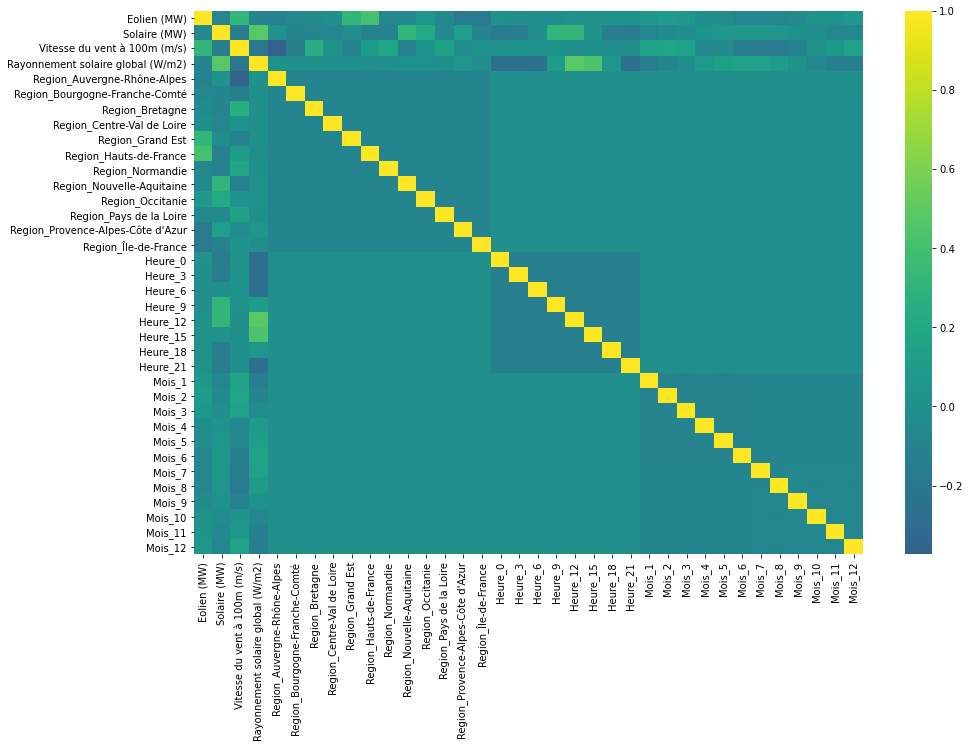

In [19]:
plt.figure(figsize=(15,10))
sns.heatmap(temp_df.corr(), annot=False, center=0, cmap='viridis');

Cela nous permet de vérifier assez rapidement quelques hypothèses qui vont être essentielles pour nos modèles:
- la vitesse du vent est corrélée avec la production éolienne
- certaines régions sont plus propices à la production éolienne que d'autres
- l'heure n'a pas d'influence sur la production éolienne (logique)
- le mois de l'année peut lui peut-être jouer avec une plus forte corrélation avec les mois d'hiver. On remarque d'ailleurs la corrélation entre vitesse du vent et mois d'hiver


**Accessoirement, on remarque que les régions avec la corrélation avec la vitesse du vent constatée la plus élevée ne sont pas les régions où il y a le plus de production éolienne, ce qui fait émerger des questions sur le positionnement du parc éolien français.**

### Premier modèle simple: la régression linéaire

Nous allons procéder à la première analyse de régression avec une régression simple visant à prévoir la production éolienne en fonction de l'heure, des paramètres météorologiques et de la région.

In [20]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

Voici les scores de cette première régression:

In [21]:
print('Score train :',lr_model.score(X_train, y_train))
print('Score test :', lr_model.score(X_test, y_test), '\n')

pred = lr_model.predict(X_train)
pred_test = lr_model.predict(X_test)
print('rmse train :', np.sqrt(mean_squared_error(y_train, pred)))
print('rmse test : ', np.sqrt(mean_squared_error(y_test, pred_test)))

Score train : 0.45441967130507843
Score test : 0.45013545183707937 

rmse train : 2048.691023444005
rmse test :  2049.7173867820397


Nous allons construire quelques graphiques pour visualiser le résultat du modèle.

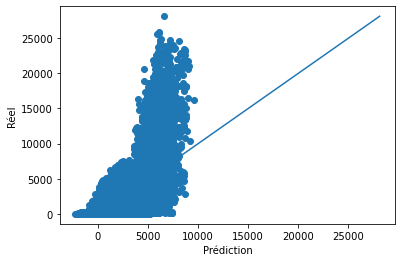

In [22]:
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()))
plt.xlabel('Prédiction')
plt.ylabel('Réel');

On constate très clairement avec ce graphique que la qualité de la régrssion est faible avec des valeurs très éloignées de la répartition attendue des données.

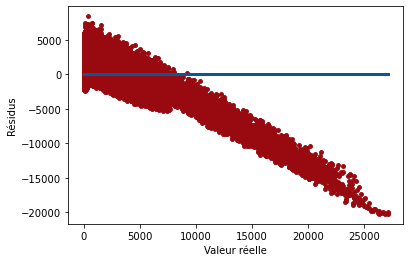

In [23]:
residus = pred-y_train
plt.scatter(y_train, residus, color='#980a10', s=15)
plt.plot((y_train.min(), y_train.max()), (0, 0), lw=3, color='#0a5798')
plt.xlabel('Valeur réelle')
plt.ylabel('Résidus');
plt.show();

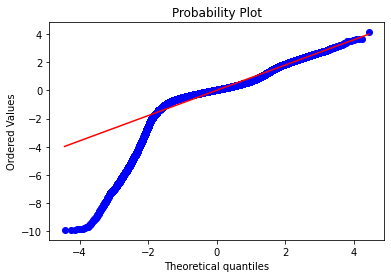

In [24]:
residus_norm = (residus - residus.mean()) / residus.std()

scipy.stats.probplot(residus_norm, plot=plt)
plt.show();

Avec ces deux derniers graphiques, nous pouvons voir que les résidus ne sont pas aléatoires (le premier, en fonction de la valeur réelle, le second en fonction des quantiles théoriques).

**Il est absolument impératif d'améliorer ce modèle.**

### Second modèle: la régression polynomiale

Nous allons appliquer une régression polynamiale d'ordre 2 et vérifier si cela améliore les performances de notre modèle.

In [25]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

LinearRegression()

In [26]:
print('Score train :', poly_model.score(X_train_poly, y_train))
print('Score test :', poly_model.score(X_test_poly, y_test), '\n')

pred = poly_model.predict(X_train_poly)
pred_test = poly_model.predict(X_test_poly)
print('rmse train :', np.sqrt(mean_squared_error(y_train, pred)))
print('rmse test : ', np.sqrt(mean_squared_error(y_test, pred_test)))

Score train : 0.582864133511044
Score test : 0.577953242359194 

rmse train : 1791.3724038849095
rmse test :  1795.752208147094


Nous avons très clairement de meilleures performances avec un overfitting limité. Voici la visualisation des prédictions et des résidus.

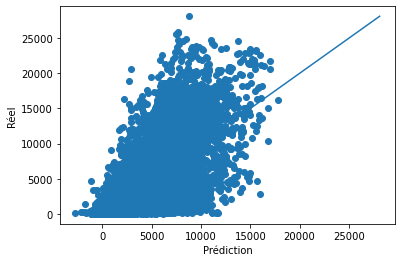

In [27]:
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()))
plt.xlabel('Prédiction')
plt.ylabel('Réel');

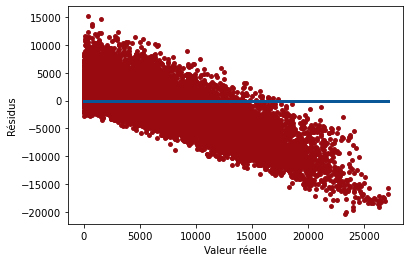

In [28]:
residus = pred-y_train
plt.scatter(y_train, residus, color='#980a10', s=15)
plt.plot((y_train.min(), y_train.max()), (0, 0), lw=3, color='#0a5798')
plt.xlabel('Valeur réelle')
plt.ylabel('Résidus');
plt.show();

### Troisième modèle: la régression avec sélections des variables pertinentes

Maintenant que nous avons une première base de comparaison, nous allons améliorer le modèle en procédant à une sélection des variables explicatives grâce à SelectKBest.

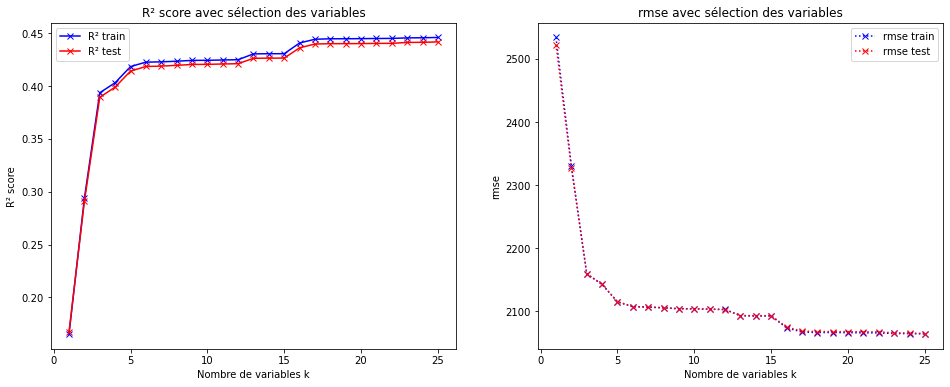

In [29]:
r2_train = []
r2_test = []
rmse_train = []
rmse_test = []

for k in range(1,26):
    sk = SelectKBest(f_regression, k=k)
    sk.fit(X=data, y=target)
    sk_train = sk.transform(X_train)
    sk_test = sk.transform(X_test)
    sklr = LinearRegression()
    sklr.fit(sk_train, y_train)
    r2_train.append(sklr.score(sk_train, y_train))
    r2_test.append(sklr.score(sk_test, y_test))
    pred = sklr.predict(sk_train)
    pred_test = sklr.predict(sk_test)
    rmse_train.append(np.sqrt(mean_squared_error(y_train, pred)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, pred_test)))
    
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(range(1,26), r2_train, label='R² train', color='blue', marker='x')
ax1.plot(range(1,26), r2_test, label='R² test', color='red', marker='x')
ax1.legend()
ax1.set_title('R² score avec sélection des variables')
ax1.set_xlabel('Nombre de variables k')
ax1.set_ylabel('R² score')
                     
ax2.plot(range(1,26), rmse_train, label='rmse train', color='blue', linestyle=':', marker='x')
ax2.plot(range(1,26), rmse_test, label='rmse test', color='red', linestyle=':', marker='x')
ax2.legend()
ax2.set_title('rmse avec sélection des variables')
ax2.set_xlabel('Nombre de variables k')
ax2.set_ylabel('rmse')                   
                     
plt.show();

Nous pouvons constater que nous retombons sur des niveaux de R² et rmse assez comparables au modèle simple sans sélection.
Ce n'est pas satisfaisant, il faudra passer à d'autres modèles. Cependant, le nombre de variables optimal dans ce contexte pourrait être 3, 6 ou 16. Quelles sont les variables associées à ces sélections?

In [30]:
sk = SelectKBest(f_regression, k=3)
sk.fit(X=data, y=target)
var_list3 = data.columns[sk.get_support()]
for i in var_list3:
    print(i)

Vitesse du vent à 100m (m/s)
Region_Grand Est
Region_Hauts-de-France


In [31]:
sk = SelectKBest(f_regression, k=6)
sk.fit(X=data, y=target)
var_list6 = data.columns[sk.get_support()]
for i in var_list6:
    print(i)

Vitesse du vent à 100m (m/s)
Region_Auvergne-Rhône-Alpes
Region_Grand Est
Region_Hauts-de-France
Region_Provence-Alpes-Côte d'Azur
Region_Île-de-France


In [32]:
sk = SelectKBest(f_regression, k=16)
sk.fit(X=data, y=target)
var_list16 = data.columns[sk.get_support()]
for i in var_list16:
    print(i)

Vitesse du vent à 100m (m/s)
Rayonnement solaire global (W/m2)
Region_Auvergne-Rhône-Alpes
Region_Bourgogne-Franche-Comté
Region_Grand Est
Region_Hauts-de-France
Region_Normandie
Region_Occitanie
Region_Provence-Alpes-Côte d'Azur
Region_Île-de-France
Mois_1
Mois_2
Mois_6
Mois_7
Mois_8
Mois_12


Nous devons donc passer sur des modèles plus élaborés car la qualité de ces régressions n'est pas satisfaisante. Nous pouvons malgré tout garder les sets de variables optimaux pour une future utilisation.

Nous pouvons d'ailleurs remarquer que le set de 16 variables est assez simple à interpréter. Il contient:
- les conditions météorologiques
- les régions les plus ou les moins productrices d'énergie éolienne
- les mois d'été
- les mois d'hiver

### Quatrième modèle: Ridge, Lasso

Les modèles Lasso ou Ridge permettent d'être plus efficaces dans les régressions. Nous allons maintenant les tester.

Nous allons utiliser une cross validation ridge avec des alphas allant de 0.001 à 100.

In [33]:
from sklearn.linear_model import RidgeCV

ridge_reg = RidgeCV(alphas=(0.001,0.01,0.1,0.3,0.7,1,10,30,50,100))
ridge_reg.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 3.e-01, 7.e-01, 1.e+00, 1.e+01, 3.e+01,
       5.e+01, 1.e+02]))

Voici l'alpha optimal et les scores de ce modèle:

In [34]:
print(f'Alpha: {ridge_reg.alpha_}')
print(f'R² Score train: {ridge_reg.score(X_train, y_train)}')
print(f'R² Score test: {ridge_reg.score(X_test, y_test)}')

Alpha: 10.0
R² Score train: 0.4544196525050712
R² Score test: 0.4501355322283721


Malheureusement, les coefficients de détermination ne sont encore une fois pas excellents. Testons Lasso.

In [35]:
from sklearn.linear_model import LassoCV

lasso_reg = LassoCV(cv=10)
lasso_reg.fit(X_train, y_train)

LassoCV(cv=10)

In [36]:
print(f'Alpha: {lasso_reg.alpha_}')
print(f'R² Score train: {lasso_reg.score(X_train, y_train)}')
print(f'R² Score test: {lasso_reg.score(X_test, y_test)}')

Alpha: 1.1280228252368578
R² Score train: 0.4543938576903127
R² Score test: 0.4501218780864893


Nous nous retrouvons dans la même situations avec des résultats peu probants. Par curiosité, examinons les coefficients de la régression:

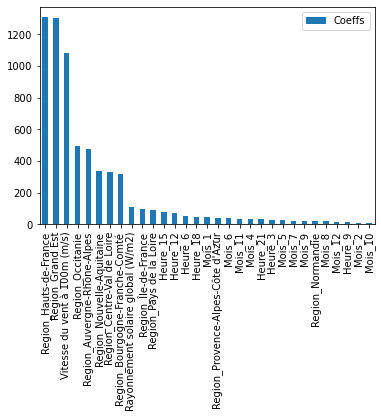

In [37]:
coef = pd.DataFrame({"Coeffs": lasso_reg.coef_}, index=list(data.columns))
coef["Coeffs"] = np.abs(coef["Coeffs"])
coef.sort_values(by='Coeffs', ascending=False, inplace=True)
coef.plot.bar();

Comme on peut le constater, beaucoup de variables ne sont pas considérées ou très peu dans l'analyse Lasso.

### Cinquième modèle: ElasticNetCV

Nous allons maintenant utiliser le modèle de régression le plus efficace, ElasticNet CV pour essayer d'améliorer notre modèle. Il combine les caractéristiques de Lasso et Ridge.

In [38]:
from sklearn.linear_model import ElasticNetCV

elnet_reg = ElasticNetCV(l1_ratio=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99), alphas=(0.001,0.01,0.1,0.3,0.7,1,10,30,50,100))
elnet_reg.fit(X_train, y_train)

ElasticNetCV(alphas=(0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 30, 50, 100),
             l1_ratio=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99))

Voici l'alpha/ratio optimal et les scores de ce modèle:

In [39]:
print(f'Alpha: {elnet_reg.alpha_}')
print(f'Ratio: {elnet_reg.l1_ratio_}')
print(f'R² Score train: {elnet_reg.score(X_train, y_train)}')
print(f'R² Score test: {elnet_reg.score(X_test, y_test)}')

Alpha: 0.001
Ratio: 0.99
R² Score train: 0.4544196707197574
R² Score test: 0.450135477504082


Nous sommes encore une fois sur des scores comparables aux modèles précédents.
Voici les variables les plus importantes dans le modèle selon leurs coefficients:

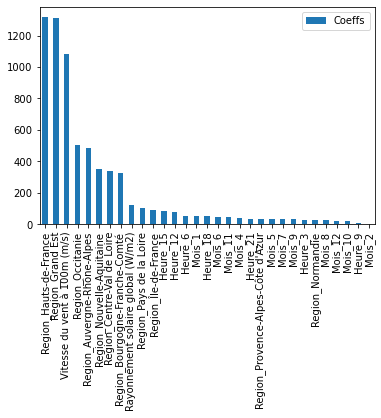

In [40]:
coef = pd.DataFrame({"Coeffs": elnet_reg.coef_}, index=list(data.columns))
coef["Coeffs"] = np.abs(coef["Coeffs"])
coef.sort_values(by='Coeffs', ascending=False, inplace=True)
coef.plot.bar();

### Sixième modèle : ElasticNetCV avec sélection de variables

Le but va être d'essayer d'améliorer le modèle en procédant à une sélection des variables grâce au SelectKBest à 16 variables trouvé précédemment.

In [41]:
sk = SelectKBest(f_regression, k=16)
sk.fit(X=data, y=target)

X_train_sk = sk.transform(X_train)
X_test_sk = sk.transform(X_test)

Nous pouvons maintenant ajuster un modèle ElasticNetCV sur cette base.

In [42]:
elnet_reg_sk = ElasticNetCV(l1_ratio=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99), alphas=(0.001,0.01,0.1,0.3,0.7,1,10,30,50,100))
elnet_reg_sk.fit(X_train_sk, y_train)

ElasticNetCV(alphas=(0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 30, 50, 100),
             l1_ratio=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99))

In [43]:
print(f'Alpha: {elnet_reg_sk.alpha_}')
print(f'Ratio: {elnet_reg_sk.l1_ratio_}')
print(f'R² Score train: {elnet_reg_sk.score(X_train_sk, y_train)}')
print(f'R² Score test: {elnet_reg_sk.score(X_test_sk, y_test)}')

Alpha: 0.001
Ratio: 0.9
R² Score train: 0.4408394244992213
R² Score test: 0.43623874598117984


Comme on peut le constater, cela n'améliore pas le modèle. Les coefficients ci-dessous sont comparables à ceux vus précédemment.

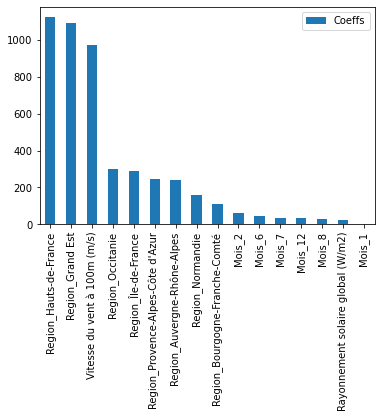

In [44]:
coef = pd.DataFrame({"Coeffs": elnet_reg_sk.coef_}, index=data.columns[sk.get_support()])
coef["Coeffs"] = np.abs(coef["Coeffs"])
coef.sort_values(by='Coeffs', ascending=False, inplace=True)
coef.plot.bar();

### Septième modèle: XGBoost Regressor

En tant que dernier modèle de régression, nous allons utiliser XGBoost et voir si nous arrivons à des résultats plus probants.

In [45]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

xgb_reg = xgb.XGBRegressor(n_estimators= 500)
param_grid_xgb = {'max_depth': [5,6,7], 'learning_rate': [0.03, 0.07, 0.1, 0.2]}
gcv_xgb = GridSearchCV(xgb_reg, param_grid_xgb, cv=3)

'''xgb_reg = xgb.XGBRegressor(verbosity=0)
xgb_reg.fit(X_train, y_train)'''

gcv_xgb.fit(X_train, y_train)
best_xgb_reg = gcv_xgb.best_estimator_
print(f'Best params: {gcv_xgb.best_params_}')

Best params: {'learning_rate': 0.07, 'max_depth': 5}


In [46]:
print(f'R² Score train: {best_xgb_reg.score(X_train, y_train)}')
print(f'R² Score test: {best_xgb_reg.score(X_test, y_test)}')

R² Score train: 0.616787470047775
R² Score test: 0.585973732882821


 Nous pouvons constater une nette amélioration du score avec le modèle xgb, même si on peut supposer un overfitting en observant la différence entre les valeurs train et test. Validons-le avec un scoring sur une cross-validation.

In [47]:
score = cross_val_score(best_xgb_reg, data, target, cv=10, scoring='r2').mean()
print(f'R² Score CV: {score}')

R² Score CV: 0.5262645884969611


Ainsi qu'avec le RMSE:

In [48]:
pred = best_xgb_reg.predict(X_train)
pred_test = best_xgb_reg.predict(X_test)
print('rmse train :', np.sqrt(mean_squared_error(y_train, pred)))
print('rmse test : ', np.sqrt(mean_squared_error(y_test, pred_test)))

rmse train : 1716.9868277555743
rmse test :  1778.6073084971226


In [49]:
score = cross_val_score(best_xgb_reg, data, target, cv=10, scoring='neg_mean_squared_error').mean()
score = score*-1
score = np.sqrt(score)

print(f'rmse CV: {score}')

rmse CV: 1840.3044311632793


Visualisons les résultats et résidus avec d'abord une comparaison prédiction vs réel sur la base de test:

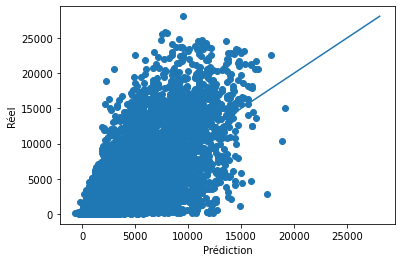

In [50]:
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()))
plt.xlabel('Prédiction')
plt.ylabel('Réel');

Ainsi que la visualisation des résidus sur l'entraînement. Si on repère certes encore une tendance, il y a une plus grande dispersion autour du 0.

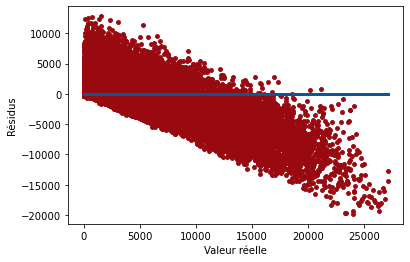

In [51]:
residus = pred-y_train
plt.scatter(y_train, residus, color='#980a10', s=15)
plt.plot((y_train.min(), y_train.max()), (0, 0), lw=3, color='#0a5798')
plt.xlabel('Valeur réelle')
plt.ylabel('Résidus');
plt.show();

**Conclusion de ces régressions: le modèle XGB donne de loin les meilleurs résultats parmi tous les modèles testés (même si la régression ploynomiale donne des résultats assez similaires). Cependant, ce n'est pas optimal car les résidus ne sont pas encore aléatoires et il y a une grande dispersion des résultats. Pourquoi?**

# Explications

Nous allons rechercher les causes potentielles de la faible qualité de cette régression et la piste la plus évidente consiste à regarder les corrélation des variables explicatives.

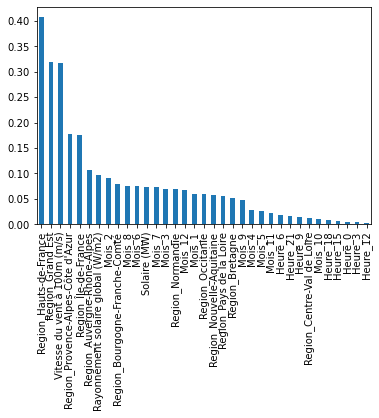

In [52]:
corr = np.abs(temp_df.corr()['Eolien (MW)']).sort_values(ascending=False)
corr.drop('Eolien (MW)', inplace=True)
corr.plot.bar();

Il y a en fait peu de corrélations intéressantes, seulement 2 régions ainsi que la vitesse du vent ont une corrélation supérieure à 0.20. La relation linéaire est peu évidente entre l'éolien et ces variables. Pourtant quand on regarde les p-values des variables, elles ont l'air en très grande majorité significatives:

In [53]:
p_values = []
for i in data.columns:
    pearstat = scipy.stats.pearsonr(data[i], target)
    p_values.append(pearstat[1])

p_val_df = pd.DataFrame(p_values, index = data.columns, columns = ['P-values'])
p_val_df

,P-values
Vitesse du vent à 100m (m/s),0.00
Rayonnement solaire global (W/m2),0.00
Region_Auvergne-Rhône-Alpes,0.00
Region_Bourgogne-Franche-Comté,0.00
Region_Centre-Val de Loire,0.00
Region_Grand Est,0.00
Region_Hauts-de-France,0.00
Region_Normandie,0.00
Region_Nouvelle-Aquitaine,0.00
Region_Occitanie,0.00


Et la région paraît significative aussi par le test ANOVA avec une p-value très faible:

In [54]:
pval_db = df.groupby(['Date','Hour', 'Code INSEE région']).sum().reset_index()
pval_db['Date'] = pd.to_datetime(pval_db['Date'], utc=True)
pval_db = pval_db.merge(right=meteo_df, on=['Date','Hour', 'Code INSEE région'], how='inner')
pval_db['Mois'] = pval_db['Date'].dt.month
pval_db.set_index(['Date - Heure'], inplace=True)
pval_db.rename({'Eolien (MW)': 'Eolien'}, axis=1, inplace=True)

In [55]:
#Test ANOVA
pd.set_option('display.float_format', lambda x: '%.3f' % x)
result = statsmodels.formula.api.ols('Eolien ~ Région', data = pval_db).fit()  
table = statsmodels.api.stats.anova_lm(result)

print('Test ANOVA')
print(table)

Test ANOVA
                 df           sum_sq         mean_sq        F  PR(>F)
Région       11.000 496818707846.671 45165337076.970 8835.347   0.000
Residual 193224.000 987740148017.766     5111891.628      NaN     NaN


**Il est possible que les variables soient significatives par quelques unes de leurs modalités (régions principales, mois d'hiver et d'été comme déjà vu avec l'analyse des corrélations). Cependant la relation existante reste faible est peu linéaire et les modèles ont donc des difficultés à être efficaces.**

**Si nous nous souvenons de l'analyse exploratoire, il s'était avéré qu'en pratique, seulement 2 régions pouvait être productrices d'énergie éolienne de manière importante (les Hauts-de-France et le Grand-Est) et ceci seulement en hiver. La conclusion de tous ces modèles est que cela ne crée pas une relation linéaire suffisante pour avoir des régressions efficaces.**

# Modèles de régression sur une base présélectionnée

Pour conclure cette analyse, nous allons combiner ce que nous savons pour essayer un autre modèle:
- de l'analyse exploratoires et du classement des corrélations ci-dessus, nous savons que seules 2 régions sont productrices d'énergie éoliennes de manière importante (Grand-Est et Hauts-de-France)
- les modèles polynomiaux et XGB Regressor donnent les meilleurs résultats sur la base complète.

Nous allons donc filtrer la database sur les 2 régions nommées ci-dessus et entraîner 2 modèles uniquement sur cela (en supprimant les variables catégorielles de région). Par la suite, nous allons également tester le modèle sur la base complète et vérifier les résultats.

In [58]:
data2 = temp_df[(temp_df['Region_Grand Est'] == 1) | (temp_df['Region_Hauts-de-France'] == 1)]
target2 = data2['Eolien (MW)']
data2 = data2.drop(['Eolien (MW)', 'Solaire (MW)', 'Region_Auvergne-Rhône-Alpes','Region_Bourgogne-Franche-Comté', 
                      'Region_Bretagne', 'Region_Centre-Val de Loire', 'Region_Grand Est', 'Region_Hauts-de-France', 
                      'Region_Normandie', 'Region_Nouvelle-Aquitaine', 'Region_Occitanie', 'Region_Pays de la Loire', 
                      "Region_Provence-Alpes-Côte d'Azur",'Region_Île-de-France', 'Heure_0', 'Mois_3'], axis=1)

Maintenant, nous allons procéder comme précédemment: split, mise à l'échelle et entraîenment avec grille.

In [63]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.2)
scaler2 = preprocessing.StandardScaler().fit(X_train2)
X_train2 = scaler2.transform(X_train2)
X_test2 = scaler2.transform(X_test2)

Voici le modèle polynomial:

In [69]:
poly2 = PolynomialFeatures(degree=2)
X_train_poly2 = poly.fit_transform(X_train2)
X_test_poly2 = poly.transform(X_test2)

poly_model2 = LinearRegression()
poly_model2.fit(X_train_poly2, y_train2)

LinearRegression()

In [70]:
print('Score train :', poly_model2.score(X_train_poly2, y_train2))
print('Score test :', poly_model2.score(X_test_poly2, y_test2), '\n')

pred = poly_model2.predict(X_train_poly2)
pred_test = poly_model2.predict(X_test_poly2)
print('rmse train :', np.sqrt(mean_squared_error(y_train2, pred)))
print('rmse test : ', np.sqrt(mean_squared_error(y_test2, pred_test)))

Score train : 0.3724635286714899
Score test : 0.38118527971836313 

rmse train : 3958.0878552675285
rmse test :  3955.7485800474014


Nous avons les pires résultats prédictifs parmi tous les modèles. Nous pouvons nous arrêter là à son sujet.
En ce qui concerne XGB:

In [65]:
xgb_reg2 = xgb.XGBRegressor(n_estimators= 500)
param_grid_xgb2 = {'max_depth': [5,6,7], 'learning_rate': [0.03, 0.07, 0.1, 0.2]}
gcv_xgb2 = GridSearchCV(xgb_reg2, param_grid_xgb2, cv=3)

gcv_xgb2.fit(X_train2, y_train2)
best_xgb_reg2 = gcv_xgb2.best_estimator_
print(f'Best params: {gcv_xgb2.best_params_}')

Best params: {'learning_rate': 0.03, 'max_depth': 5}


In [66]:
print(f'R² Score train: {best_xgb_reg2.score(X_train2, y_train2)}')
print(f'R² Score test: {best_xgb_reg2.score(X_test2, y_test2)}')

R² Score train: 0.44518049026992224
R² Score test: 0.388671595734009


In [67]:
pred = best_xgb_reg2.predict(X_train2)
pred_test = best_xgb_reg2.predict(X_test2)
print('rmse train :', np.sqrt(mean_squared_error(y_train2, pred)))
print('rmse test : ', np.sqrt(mean_squared_error(y_test2, pred_test)))

rmse train : 3721.703802746817
rmse test :  3931.747780510945


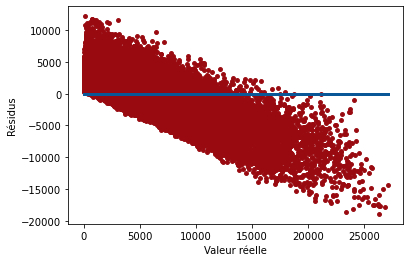

In [68]:
residus = pred-y_train2
plt.scatter(y_train2, residus, color='#980a10', s=15)
plt.plot((y_train2.min(), y_train2.max()), (0, 0), lw=3, color='#0a5798')
plt.xlabel('Valeur réelle')
plt.ylabel('Résidus');
plt.show();

Encore une fois, ce n'est absolument pas une amélioration bien au contraire (même s'il fonctionne mieux que le polynomial). Si nous regardons les corrélations dans cette database filtrée, nous pouvons voir qu'une seule variable compte, la vitesse du vent.

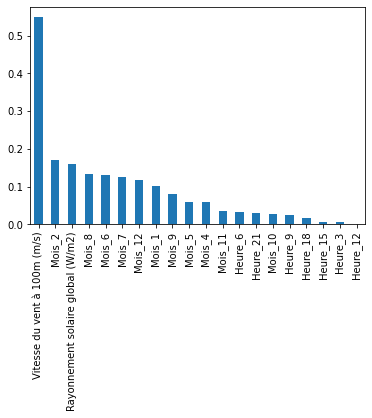

In [131]:
data_corr = data2.join(target2)
corr = np.abs(data_corr.corr()['Eolien (MW)']).sort_values(ascending=False)
corr.drop('Eolien (MW)', inplace=True)
corr.plot.bar();

De plus cette vitesse du vent, si elle varie avec les saisons, ne varie que relativement peu là où la production éolienne était plus que doublée en hiver dans les régions concernées. **Cela peut être une explication des difficultés de ces modèles: s'il existe une relation, elle est loin d'être consistante dans le temps**

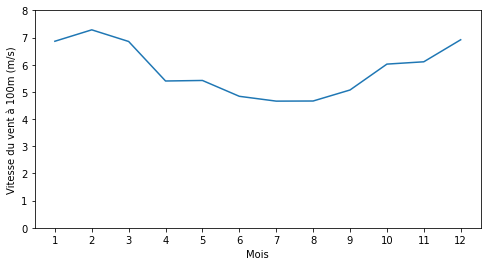

In [132]:
data_corr['Mois'] = data_corr.index.month
data_corr = data_corr.groupby(['Mois']).mean().reset_index()
fig, ax = plt.subplots(figsize=(8,4))
g = sns.lineplot(x= 'Mois', y='Vitesse du vent à 100m (m/s)', ax=ax, data=data_corr)
g.set_yticks(range(0,9))
g.set_xticks(range(1,13));

Appliquons ces modèles sur le reste de la database:

In [72]:
data_other = temp_df[(temp_df['Region_Grand Est'] == 0) & (temp_df['Region_Hauts-de-France'] == 0)]
target_other = data_other['Eolien (MW)']
data_other = data_other.drop(['Eolien (MW)', 'Solaire (MW)', 'Region_Auvergne-Rhône-Alpes','Region_Bourgogne-Franche-Comté', 
                      'Region_Bretagne', 'Region_Centre-Val de Loire', 'Region_Grand Est', 'Region_Hauts-de-France', 
                      'Region_Normandie', 'Region_Nouvelle-Aquitaine', 'Region_Occitanie', 'Region_Pays de la Loire', 
                      "Region_Provence-Alpes-Côte d'Azur",'Region_Île-de-France', 'Heure_0', 'Mois_3'], axis=1)

data_other_scaled = scaler2.transform(data_other)

In [74]:
print(f'R² Score other: {best_xgb_reg2.score(data_other_scaled, target_other)}')
pred = best_xgb_reg2.predict(data_other_scaled)
print('rmse other :', np.sqrt(mean_squared_error(target_other, pred)))

R² Score other: -15.01799168209292
rmse other : 4972.148692708952


Comme attendu, ces scores sont désastreux.

# Conclusions

Il apparaît impossible d'obtenir une meilleure régression que celle effectuée sur la base complète avec un XGBoost Regressor qui avait un R² score de 0.58 sur la base de test, ce qui n'est pas optimal.

Le modèle:
- prédit mal les valeurs importantes (résidus croissant avec la valeur réelle)
- a au final peu de variables explicatives significatives (seulement les 2 régions les plus productrices d'énergie éolienne et la vitesse du vent).

Si on revient sur l'analyse exploratoire et les corrélations, il y a des pistes d'explications à cette non-linéarité:
- la vitesse du vent n'est pas une corrélation claire avec la production éolienne car les régions qui avaient les vents les plus importants ne produisent pas d'énergie éolienne. **On revient sur la question du placement des éoliennes en France.**
- les régions sont extrêmement disparates entre elles avec certaines qui n'ont quasiment pas de capacité de production, ce qui fausse l'analyse
- et même parmi celles qui ont des capacités de production, la production n'est pas clairement linéaire avec la vitesse du vent ou la période de l'année.